# Modelo de simulación de la dinámica de dos variables con ruido gaussinao en un tiempo discreto


Describimos un sistema periódico con términos de ruido especficados más adealante en tiempo discreto. Analizaremos la matriz de covarinza creada por las variables y trazaremos un diagrama de dispersión. Aplicando PCA sacamos los autovectores que nos daran la mayor variabilidad de los datos.
A continuación, calculamos la transformada de Fourier con una frecuencia $\omega$ para poder clasificar los autovectores en aquellos que pertencen al ruido $\omega =0$ y los que pertenecen a la función periódica ($\omega=\omega _0$).

Con este método intentamos mostrar un herramienta que más adelante se utilizará en el estudio de la red neuronal.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

Definimos las funciones que vamos a utilizar: la delta de Dirac como una delta de Kronecker y el método de deflación 

In [ ]:
def diracdelta(w,w0): #definimos la delta de dirac con el modelo de encarni del seno cardinal
    if w==np.abs(w0): return 1 
    if w!=w0: return 0

def metodo_potencia(C, iter=1000, tol=1e-6):
    n, _ = C.shape
    b_k = np.random.rand(n)
    b_k=b_k/np.linalg.norm(b_k)  # Vector inicial simbólico de modulo la unidad
    for _ in range(iter):
        b_k1 = np.dot(C,b_k)
        b_k1_norm = np.linalg.norm(b_k1)
        if b_k1_norm == 0:
            raise ValueError("La matriz tiene un autovalor 0")
        
        b_k = b_k1 / b_k1_norm
        
        if np.linalg.norm(np.dot(C,b_k)-b_k1_norm*b_k)<tol:
            break
    autovector=b_k
    autovalor = np.dot(autovector.conj().conj(), np.dot(C, autovector))
   
    return autovalor,autovector
def metodo_potencia_todos_autovalores(C, iter=100, tol=1e-6): 
    #se hace por un método de deflación y se hace de manera simbolica. Debido a que el método de la potencia me da el autvalor dominante de la matriz C
    # una vez calculado yo quito ese autovalor y empiezo de nuevo con el método.
    
    n, _ = C.shape
    autovalores = []
    autovectores= []
    C_defl = C.copy()  # Copiamos la matriz original
    
    for _ in range(n):
        [autovalor, autovector] = metodo_potencia(C_defl, iter, tol) #cojo el método de la potencia
        autovalores.append(autovalor)#metemos al final de la lista de autovalores el autovalor calculado por el metodo de la potencia
        autovectores.append(autovector)
        # Construimos la matriz de deflación: C' = C - autovalor * (autovector * autovector.Transpuesto)
        autovector = autovector / np.linalg.norm(autovector)  # Normalizamos autovector
        C_defl = C_defl - autovalor*np.outer(autovector,autovector.conj()) #otuer es el producto externo de autovector por su conjugado
    
    return autovalores, autovectores

Definimos los parámetros que vamos a utilizar: amplitudes, retrasos, ruido... y las variables x1(t) y x2(t)

[[ 0.99391537 -0.78908288]
 [-0.78908288  0.98792299]]


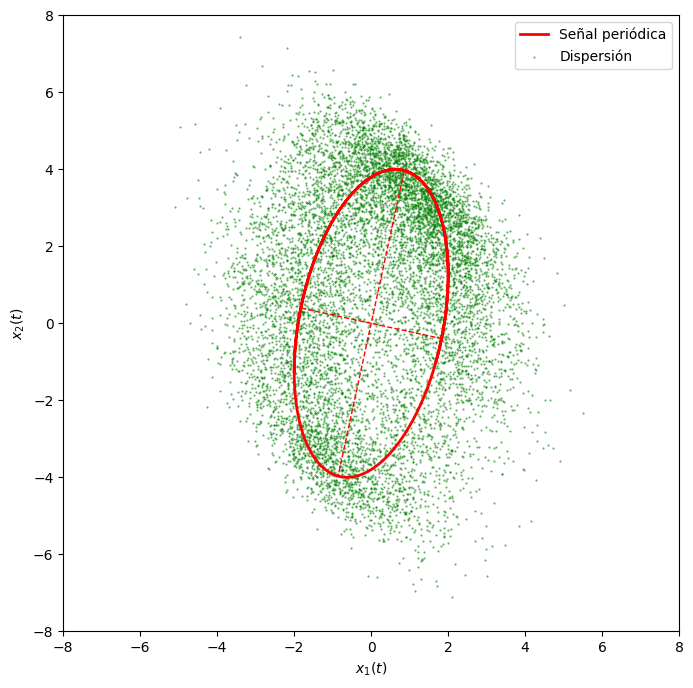

In [3]:
#Variables: amplitudes de la función peródica, parámetro de desfase, 
# discretización del tiempo, frecuencia angular de la función periódica.
v1,v2=-2, 4
epsilon=0
delay =2*np.pi/1.43
t=np.linspace(0,10,10000)
w0=1 

# Ruido Gaussiano con correlación cruzada
rho = -0.8  # Correlación cruzada (-1 <= rho <= 1)
media = [0,0]  # Media del ruido
cov = [[1, rho], [rho, 1]]  # Matriz de covarianza
ruido = np.random.multivariate_normal(media, cov, size=len(t)) #Ruido con la correlacion de 0.8

xi1 = ruido[:, 0] 
xi2 = ruido[:, 1]  

#Mostramos el resultado para ver si concuerda con lo teorizado.
covarianza=np.cov(xi1,xi2)
print(covarianza)

#Describimos las variables
x1=v1*np.cos(w0*t+epsilon)+xi1
x2=v2*np.cos(w0*t+epsilon+delay)+xi2

#Trayectoria de la señal periódica
eta1=v1*np.cos(w0*t+epsilon)
eta2=v2*np.cos(w0*t+epsilon+delay)

#Creamos a la matriz de datos 
X = np.vstack((eta1, eta2))
# Calculamos la matriz de covarianza
C = np.cov(X)
# Obtenemos autovalores y autovectores
autovalores, autovectores = np.linalg.eig(C)

fig, ax = plt.subplots(figsize=(10,8))

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)

# Dibujamos los autovectores (direcciones principales de variabilidad)

chi2_val = [1.4,1.5] #Factor de escala sacado con la distribución chi cuadrado
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

# Trazar el diagrama de dispersión de los datos simulados
ax.scatter(x1, x2, s=0.3, label='Dispersión', color='green', alpha=0.6)
ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()


Para hallar el elipsoide que me describe las direcciones de máxima variabilidad de ruido cogemos el primer término de la ecuación C

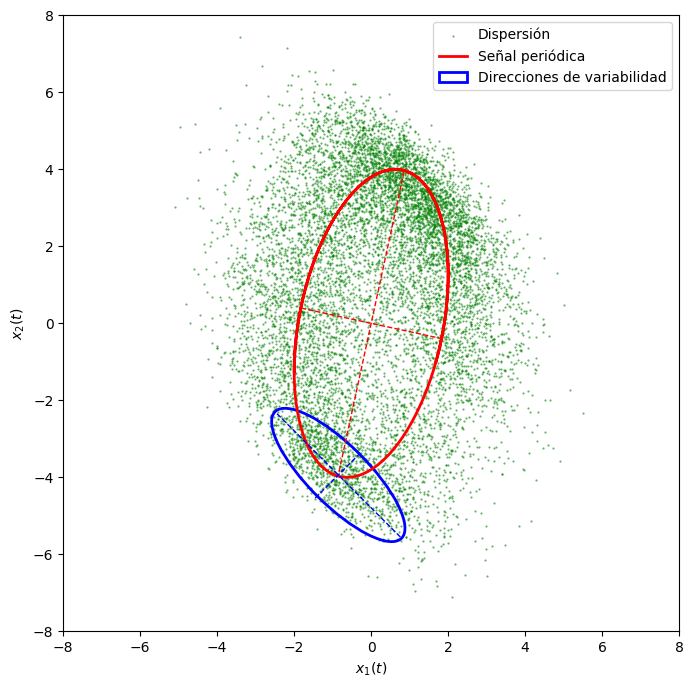

In [38]:
matriz_ruido=np.array([
    [1, rho],
    [rho, 1]
])
#Hallamos sus autovectores. Y creamos la elipse con las direcciones de los autovectores de la matriz de ruido

autovalores_ruido,autovectores_ruido=metodo_potencia_todos_autovalores(matriz_ruido)
autovectores_ruido=np.array(autovectores_ruido)
autovalores_ruido=np.array(autovalores_ruido)
orden = np.argsort(autovalores_ruido)[::-1]
autovalores_ruido = autovalores_ruido[orden]
autovectores_ruido =autovectores_ruido[:, orden]

# Para dibujar elipses, definimos el nivel de confianza (por ejemplo, 95%)
# El factor de escalado se puede obtener usando el percentil de la distribución chi-cuadrado 
chi2_val = 3
# Longitudes de los ejes de la elipse:
width = 2 * np.sqrt(autovalores_ruido[0] * chi2_val)
height = 2 * np.sqrt(autovalores_ruido[1] * chi2_val)

# Ángulo de rotación (en grados) a partir del eigenvector mayor:
angle = np.degrees(np.arctan2(autovectores_ruido[1, 0],autovectores_ruido[0, 0]))


# Creamos la figura
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x1, x2, s=0.3, label='Dispersión', color='green', alpha=0.6)

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)

# Dibujamos los autovectores (direcciones principales de variabilidad de la señal periódica)

chi2_val = [1.4,1.5] #Factor de escala 
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

chi2_valu=[1.7,1.9]
for i in range(2):
    vec1 = autovectores_ruido[:, i] * np.sqrt(autovalores_ruido[i])*chi2_valu[i]
    ax.plot([-vec1[0]+vec[0],  vec1[0]+vec[0]], [-vec1[1]+vec[1], vec1[1]+vec[1]], 'b--', linewidth=1)

# Dibujamos el elipse que representa la forma del ruido con origen en (vec[0],vec[1])
ellipse = Ellipse(xy=(vec[0],vec[1]), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='None', lw=2, label='Direcciones de variabilidad')
ax.add_patch(ellipse)

ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()

Definimos las matrices que usaremos y que darán la varibilidad del diagrama de dispersión. Estas matrices son, respectivamente, la matriz de covarianza de las varibles x1(t),x2(t) implementadas en un tiempo de disparo $\tau$ =0.0 y la transformada de Fourier con un w relacionado con w0.

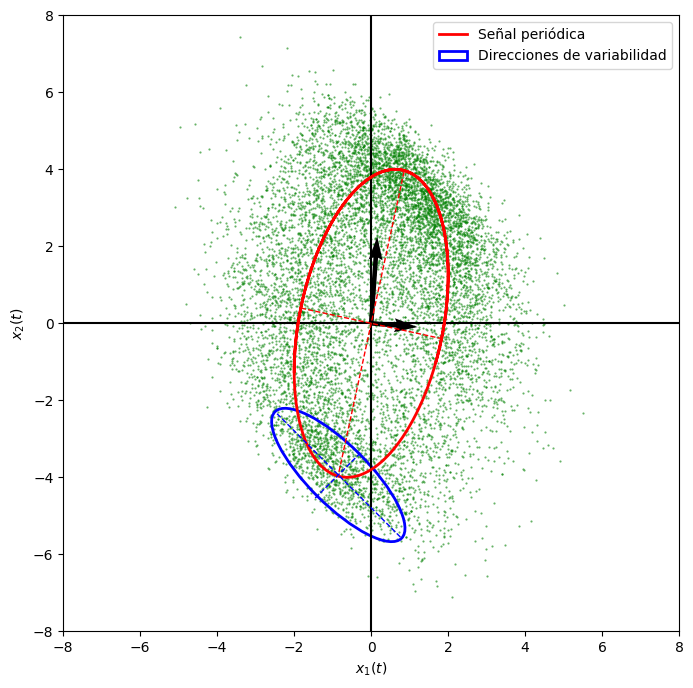

In [6]:
#Defino la matriz  C (hecho de forma analítica)
tau=.0
C = np.array([
    [1 * diracdelta(tau,0) + 0.5 * v1**2 * np.cos(w0 * tau), 1 * rho * diracdelta(tau,0) + 0.5 * v1 * v2 * np.cos(w0 * tau + delay)],
    [rho * 1 * diracdelta(tau,0) + 0.5 * v1 * v2 * np.cos(w0 * tau - delay), 1 * diracdelta(tau,0) + 0.5 * v2**2 * np.cos(w0 * tau)]
], dtype=float) #defino el tipo de variable

autovalores_de_c,autovectores_de_c=metodo_potencia_todos_autovalores(C)
autovectores_de_c = np.array(autovectores_de_c)

# Creamos la figura
fig, ax = plt.subplots(figsize=(10,8))
#Ploteamos los ejes
x=[-8,8]
y=[0,0]
ax.plot(x,y, label='',color= 'black')
x=[0,0]
y= [-8,8]
ax.plot(x,y, label='',color= 'black')
ax.scatter(x1, x2, s=0.3, color='green', alpha=0.6)

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)

# Dibujamos los autovectores (direcciones principales de variabilidad de la señal periódica)

chi2_val = [1.4,1.5] #Factor de escala sacado con la distribución chi cuadrado
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

chi2_valu=[1.7,1.9]
for i in range(2):
    vec1 = autovectores_ruido[:, i] * np.sqrt(autovalores_ruido[i])*chi2_valu[i]
    ax.plot([-vec1[0]+vec[0],  vec1[0]+vec[0]], [-vec1[1]+vec[1], vec1[1]+vec[1]], 'b--', linewidth=1)

# Dibujar el elipse que representa la forma del ruido
ellipse = Ellipse(xy=(vec[0],vec[1]), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='None', lw=2, label='Direcciones de variabilidad')
ax.add_patch(ellipse)

#Ploteamos los autovectores con un factor de escala chi2_val
origin = np.array([0, 0])
for i in range(2):
    vec = autovectores_de_c[:, i] * np.sqrt(autovalores_de_c[i])*chi2_val
    ax.quiver(*origin, vec[0], vec[1], angles='xy', scale_units='xy', scale=2, color='black')


ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()

A continuación, tenemos que hacer la transforma de Fourier de la matriz C, que nos da S. También esta hecho de forma analitica.
Aquí, hay que distinguir dos tipo de $\omega$, ya que hay una delta de dirac que esta definida de forma binaria.
Ploteamos a continuación los vectores en el diagrama de dispersión. El resultado esperado será que las direcciones de variabilidad correspondientes al ruido $\omega=0$. 

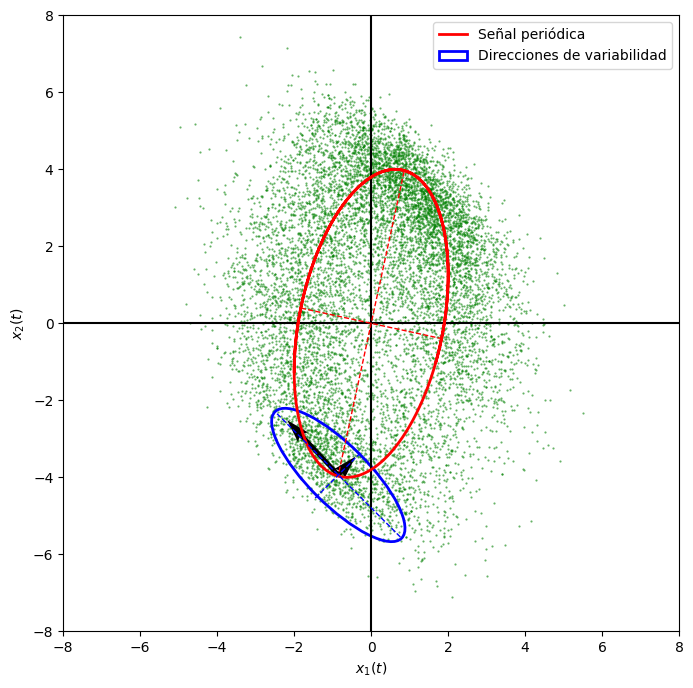

In [8]:
w=0
producto=diracdelta(w,w0)

N=np.array([
    [v1**2, np.dot(v1,v2)*np.exp(-delay*w/w0)],
    [v1*v2*np.exp(delay*w/w0), v2**2]
])

S=matriz_ruido+np.pi*diracdelta(w,w0)*N/2
autovalores2,autovectores_de_S=metodo_potencia_todos_autovalores(S)

autovectores_de_S = np.array(autovectores_de_S)

# Creamos la figura
fig, ax = plt.subplots(figsize=(10,8))
#Ploteamos los ejes
x=[-8,8]
y=[0,0]
ax.plot(x,y, label='',color= 'black')
x=[0,0]
y= [-8,8]
ax.plot(x,y, label='',color= 'black')
ax.scatter(x1, x2, s=0.3, color='green', alpha=0.6)

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)

# Dibujamos los autovectores (direcciones principales de variabilidad de la señal periódica)

chi2_val = [1.4,1.5] #Factor de escala sacado con la distribución chi cuadrado
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

chi2_valu=[1.7,1.9]
for i in range(2):
    vec1 = autovectores_ruido[:, i] * np.sqrt(autovalores_ruido[i])*chi2_valu[i]
    ax.plot([-vec1[0]+vec[0],  vec1[0]+vec[0]], [-vec1[1]+vec[1], vec1[1]+vec[1]], 'b--', linewidth=1)


# Dibujar el elipse que representa la forma del ruido
ellipse = Ellipse(xy=(vec[0],vec[1]), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='None', lw=2, label='Direcciones de variabilidad')
ax.add_patch(ellipse)

#Ploteamos los autovectores
origin = np.array([vec[0], vec[1]])
for i in range(2):
    vec = autovectores_de_S[:, i] * np.sqrt(autovalores2[i])*chi2_val
    ax.quiver(*origin, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color='black')


ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()

Hacemos lo  mismo para cuando w=w0.

[[ 0.15990429  0.98713252]
 [ 0.98713253 -0.15990425]]


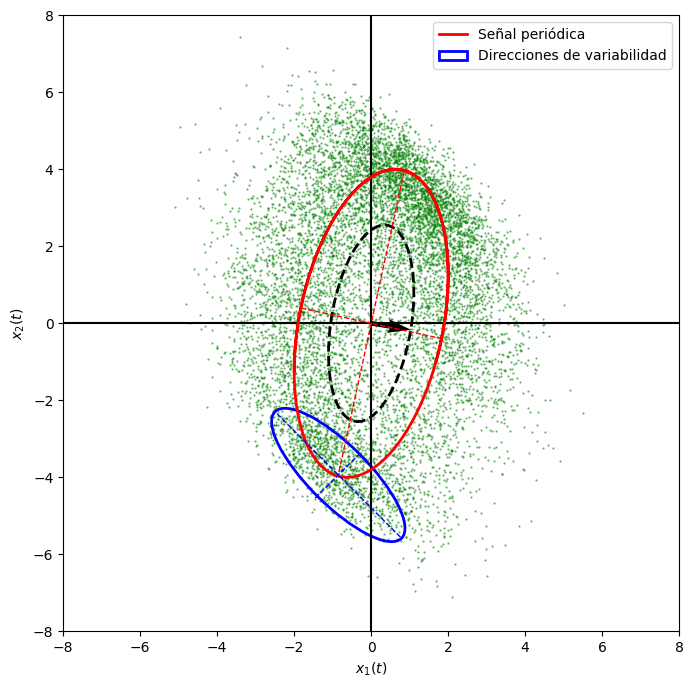

In [70]:
w=w0
producto=diracdelta(w,w0)

N=np.array([
    [v1**2, np.dot(v1,v2)*np.cos(delay)],
    [v1*v2*np.cos(delay), v2**2]
])

S=matriz_ruido+np.pi*diracdelta(w,w0)*N/2

autovalores2,autovectores_de_S1=metodo_potencia_todos_autovalores(S)
autovectores_de_S1 = np.array(autovectores_de_S1)
print(autovectores_de_S1)
# Creamos una figura y el diagrama de dispersión
# Creamos la figura
fig, ax = plt.subplots(figsize=(10,8))
#Ploteamos los ejes
x=[-8,8]
y=[0,0]
ax.plot(x,y, label='',color= 'black')
x=[0,0]
y= [-8,8]
ax.plot(x,y, label='',color= 'black')
ax.scatter(x1, x2, s=0.3, color='green', alpha=0.6)

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)
 #Factor de escala sacado con la distribución chi cuadrado
# Elipse negra discontinua para la matriz S
chi3_val = [0.5,0.4] #Factor de escala sacado con la distribución chi cuadrado]
angle_S = np.degrees(np.arctan2(autovectores_de_S1[1, 1], autovectores_de_S1[0, 1]))
width_S = 2 * np.sqrt(autovalores2[1]) * chi3_val[1]
height_S = 2 * np.sqrt(autovalores2[0]) * chi3_val[0]

elipse_S = Ellipse(xy=(0, 0), width=width_S, height=height_S, angle=angle_S,
                   edgecolor='black', fc='None', lw=2, ls='--')

ax.add_patch(elipse_S)

# Dibujamos los autovectores (direcciones principales de variabilidad de la señal periódica)

chi2_val = [1.4,1.5] #Factor de escala sacado con la distribución chi cuadrado
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

chi2_valu=[1.7,1.9]
for i in range(2):
    vec1 = autovectores_ruido[:, i] * np.sqrt(autovalores_ruido[i])*chi2_valu[i]
    ax.plot([-vec1[0]+vec[0],  vec1[0]+vec[0]], [-vec1[1]+vec[1], vec1[1]+vec[1]], 'b--', linewidth=1)


# Dibujar el elipse que representa la forma del ruido
ellipse = Ellipse(xy=(vec[0],vec[1]), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='None', lw=2, label='Direcciones de variabilidad')
ax.add_patch(ellipse)

#Ploteamos los autovectores
origin = np.array([0, 0])

# Elegimos el autovector principal (asumimos el mayor es el de índice 1, puedes verificar esto)
indice_principal = 1  # Cambia a 0 si ese es el eje mayor

# Usamos el mismo factor que la elipse (chi2_val[indice_principal])
modulo_vec = np.sqrt(autovalores2[indice_principal]) * chi3_val[indice_principal]
vec_S = autovectores_de_S1[:, indice_principal] * modulo_vec

# Dibujamos con quiver el autovector escalado para que esté contenido en la elipse
ax.quiver(*origin, vec_S[0], vec_S[1], angles='xy', scale_units='xy', scale=1, color='black')

ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()

En el diagrama anterior sólo se plotea uno de los autovectores debido a la naturaleza de número imaginario que tiene el otro autovector.

Por último, repetimos lo hecho en el modelo anterior con diferentes parámetros (el parámetro clave será el desfase elegido)

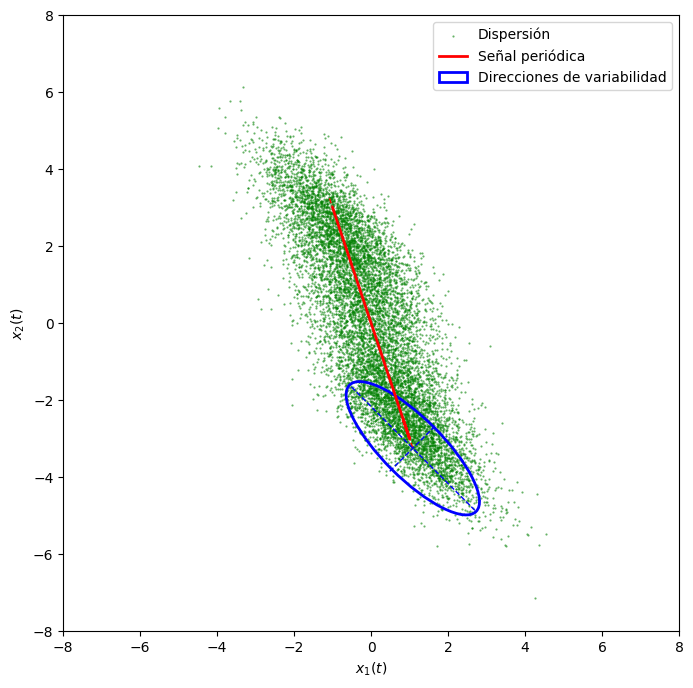

In [64]:
v1,v2 = -1,3 
delay= 0
#Describimos las variables
x1=v1*np.cos(w0*t+epsilon)+xi1
x2=v2*np.cos(w0*t+epsilon+delay)+xi2

#Trayectoria de la señal periódica
eta1=v1*np.cos(w0*t+epsilon)
eta2=v2*np.cos(w0*t+epsilon+delay)

#La matriz de covarianza de las etas dan la matriz eta

#Creamos a la matriz de datos 
X = np.vstack((eta1, eta2))
# Calculamos la matriz de covarianza
C = np.cov(X)
# Obtenemos autovalores y autovectores
autovalores, autovectores = np.linalg.eig(C)

# Creamos la figura
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x1, x2, s=0.3, label='Dispersión', color='green', alpha=0.6)

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)

# Dibujamos los autovectores (direcciones principales de variabilidad de la señal periódica)

chi2_val = [1.4,1.5] #Factor de escala sacado con la distribución chi cuadrado
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

chi2_valu=[1.7,1.9]
for i in range(2):
    vec1 = autovectores_ruido[:, i] * np.sqrt(autovalores_ruido[i])*chi2_valu[i]
    ax.plot([-vec1[0]+vec[0],  vec1[0]+vec[0]], [-vec1[1]+vec[1], vec1[1]+vec[1]], 'b--', linewidth=1)


# Dibujar el elipse que representa la forma del ruido
ellipse = Ellipse(xy=(vec[0],vec[1]), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='None', lw=2, label='Direcciones de variabilidad')
ax.add_patch(ellipse)

ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()

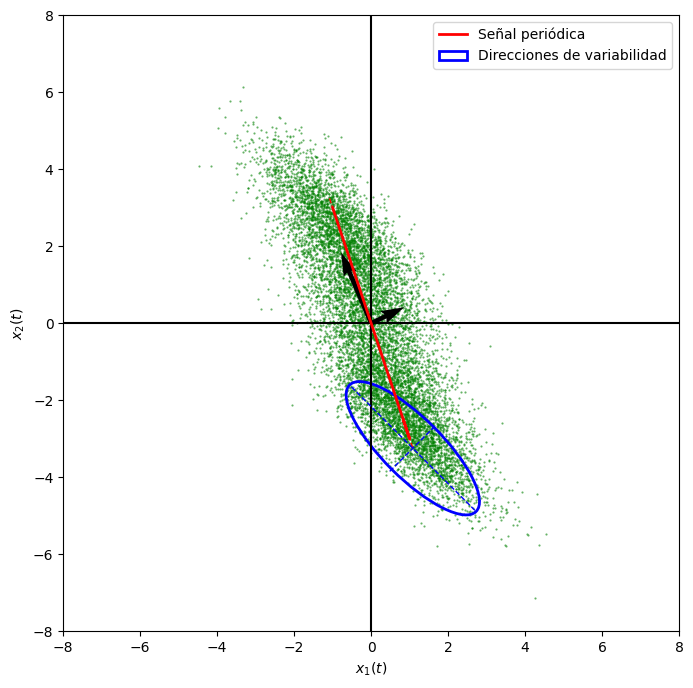

In [95]:
#Defino la matriz  C (hecho de forma analítica)
tau=.0
C = np.array([
    [1 + 0.5 * v1**2 * np.cos(w0 * tau), 1 * rho + 0.5 * v1 * v2 * np.cos(w0 * tau + delay)],
    [rho * 1 + 0.5 * v1 * v2 * np.cos(w0 * tau - delay), 1 + 0.5 * v2**2 * np.cos(w0 * tau)]
], dtype=float) #defino el tipo de variable

autovalores_de_c,autovectores1=metodo_potencia_todos_autovalores(C)

#Debido a la naturaleza de los autovectores, voy a cambiarle el signo a una fila
autovectores1[0]=-autovectores1[0]
autovectores_de_c = np.array(autovectores1)

# Creamos la figura
fig, ax = plt.subplots(figsize=(10,8))
#Ploteamos los ejes
x=[-8,8]
y=[0,0]
ax.plot(x,y, label='',color= 'black')
x=[0,0]
y= [-8,8]
ax.plot(x,y, label='',color= 'black')
ax.scatter(x1, x2, s=0.3, color='green', alpha=0.6)

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)

# Dibujamos los autovectores (direcciones principales de variabilidad de la señal periódica)

chi2_val = [1.4,1.5] #Factor de escala sacado con la distribución chi cuadrado
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

chi2_valu=[1.7,1.9]
for i in range(2):
    vec1 = autovectores_ruido[:, i] * np.sqrt(autovalores_ruido[i])*chi2_valu[i]
    ax.plot([-vec1[0]+vec[0],  vec1[0]+vec[0]], [-vec1[1]+vec[1], vec1[1]+vec[1]], 'b--', linewidth=1)


# Dibujar el elipse que representa la forma del ruido
ellipse = Ellipse(xy=(vec[0],vec[1]), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='None', lw=2, label='Direcciones de variabilidad')
ax.add_patch(ellipse)

#Ploteamos los autovectores
origin = np.array([0, 0])
escala=[1.9,1]
for i in range(2):
    vec = autovectores_de_c[:, i] * np.sqrt(autovalores_de_c[i])*chi2_val
    ax.quiver(*origin, vec[0], vec[1], angles='xy', scale_units='xy', scale=escala[i], color='black')


ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()

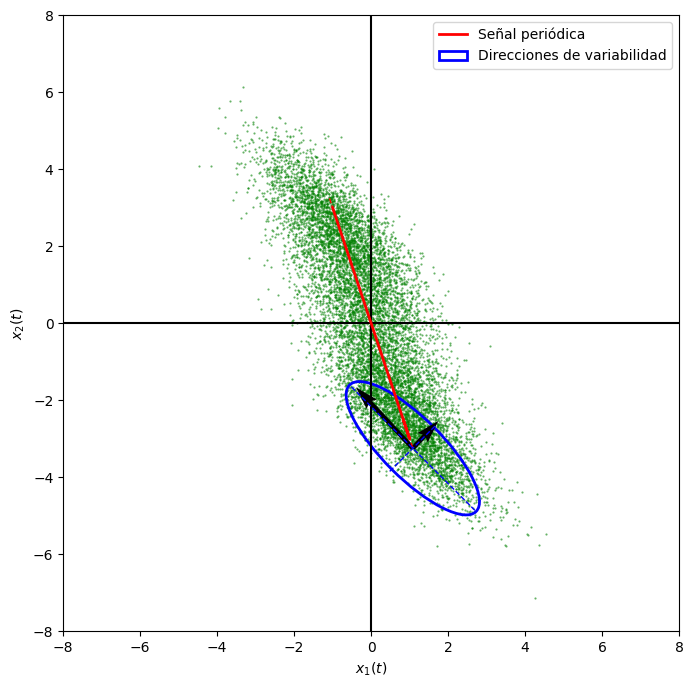

In [108]:
w=0
producto=diracdelta(w,w0)

N=np.array([
    [v1**2, np.dot(v1,v2)*np.exp(-delay*w/w0)],
    [v1*v2*np.exp(delay*w/w0), v2**2]
])

S=matriz_ruido+np.pi*diracdelta(w,w0)*N/2

autovalores2,autovectores2=metodo_potencia_todos_autovalores(S)

autovectores2[0]=-autovectores2[0]
autovectores_de_S = np.array(autovectores2)

# Creamos la figura
fig, ax = plt.subplots(figsize=(10,8))
#Ploteamos los ejes
x=[-8,8]
y=[0,0]
ax.plot(x,y, label='',color= 'black')
x=[0,0]
y= [-8,8]
ax.plot(x,y, label='',color= 'black')
ax.scatter(x1, x2, s=0.3, color='green', alpha=0.6)

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)

# Dibujamos los autovectores (direcciones principales de variabilidad de la señal periódica)

chi2_val = [1.4,1.5] #Factor de escala sacado con la distribución chi cuadrado
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

chi2_valu=[1.7,1.9]
for i in range(2):
    vec1 = autovectores_ruido[:, i] * np.sqrt(autovalores_ruido[i])*chi2_valu[i]
    ax.plot([-vec1[0]+vec[0],  vec1[0]+vec[0]], [-vec1[1]+vec[1], vec1[1]+vec[1]], 'b--', linewidth=1)


# Dibujar el elipse que representa la forma del ruido
ellipse = Ellipse(xy=(vec[0],vec[1]), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='None', lw=2, label='Direcciones de variabilidad')
ax.add_patch(ellipse)

#Ploteamos los autovectores
origin = np.array([vec[0], vec[1]])
escala=[2,0.3]
for i in range(2):
    vec = autovectores_de_S[:, i] * np.sqrt(autovalores2[i])*chi2_val
    ax.quiver(*origin, vec[0], vec[1], angles='xy', scale_units='xy', scale=escala[i], color='black')

ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()

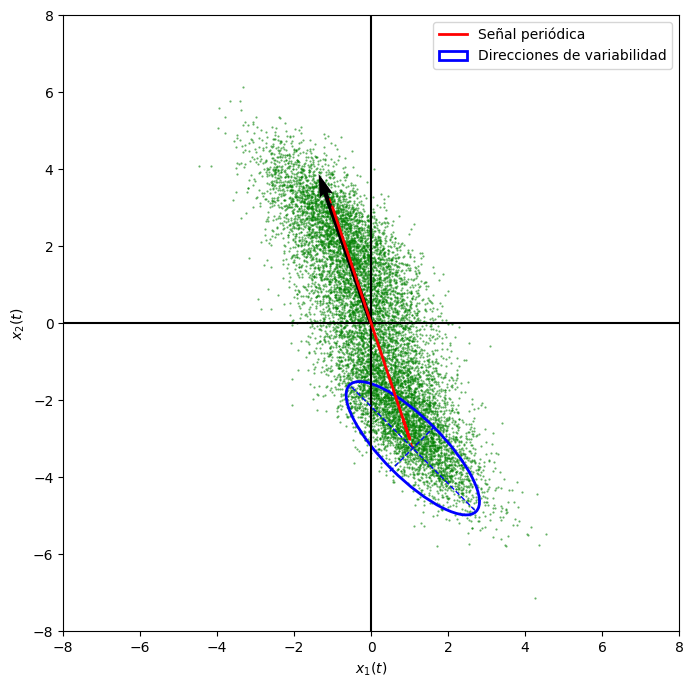

In [114]:
w=w0
producto=diracdelta(w,w0)

N=np.array([
    [v1**2, np.dot(v1,v2)*np.cos(delay)],
    [v1*v2*np.cos(delay), v2**2]
])

S=matriz_ruido+np.pi*diracdelta(w,w0)*N/2

autovalores_de_S,autovectores_de_S=metodo_potencia_todos_autovalores(S,iter=1000,tol=1e-6)
autovalores2,autovectores2=metodo_potencia_todos_autovalores(S)

autovectores_de_S = np.array(autovectores_de_S)

# Creamos una figura y el diagrama de dispersión
# Creamos la figura
fig, ax = plt.subplots(figsize=(10,8))
#Ploteamos los ejes
x=[-8,8]
y=[0,0]
ax.plot(x,y, label='',color= 'black')
x=[0,0]
y= [-8,8]
ax.plot(x,y, label='',color= 'black')
ax.scatter(x1, x2, s=0.3, color='green', alpha=0.6)

# Trazar la elipse ideal
ax.plot(eta1, eta2, label='Señal periódica', color='red', linewidth=2)

# Dibujamos los autovectores (direcciones principales de variabilidad de la señal periódica)

chi2_val = [1.4,1.5] #Factor de escala sacado con la distribución chi cuadrado
for i in range(2):
    vec = autovectores[:, i] * np.sqrt(autovalores[i])*chi2_val[i]
    ax.plot([-vec[0],  vec[0]], [-vec[1], vec[1]], 'r--', linewidth=1)

chi2_valu=[1.7,1.9]
for i in range(2):
    vec1 = autovectores_ruido[:, i] * np.sqrt(autovalores_ruido[i])*chi2_valu[i]
    ax.plot([-vec1[0]+vec[0],  vec1[0]+vec[0]], [-vec1[1]+vec[1], vec1[1]+vec[1]], 'b--', linewidth=1)


# Dibujar el elipse que representa la forma del ruido
ellipse = Ellipse(xy=(vec[0],vec[1]), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='None', lw=2, label='Direcciones de variabilidad')
ax.add_patch(ellipse)

#Ploteamos los autovectores
origin = np.array([0, 0])
escala=[1.5,1]
for i in range(1):
    vec = autovectores_de_S[:, i] * np.sqrt(autovalores_de_S[i])*chi2_val
    ax.quiver(*origin, vec[0], vec[1], angles='xy', scale_units='xy', scale=escala[i], color='black')


ax.set_xlabel("$x_1(t)$")
ax.set_ylabel("$x_2(t)$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend()
ax.set_aspect('equal')

plt.show()

De la misma forma que pasaba con su análogo, uno de los autovectores cae en el plano complejo.